### Установка BigARTM

Bigartm по-разному ставится для разных ОС. Инструкцию под вашу ОС можно найти тут - https://bigartm.readthedocs.io/en/stable/installation/index.html

Там можно пропустить установку питона и пипа.

(Если у вас не получается установить, попробуйте тетрадку для колаба или напишите мне)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive') #, force_remount=True

Mounted at /content/gdrive


In [2]:
import os
os.chdir('gdrive/My Drive/Colab Notebooks')

In [3]:
pip install bigartm

     |████████████████████████████████| 1.9MB 3.8MB/s 


In [ ]:
!pip install pymorphy2
!pip install pymystem3==0.1.10
!pip install rusenttokenize
!pip install razdel

In [5]:
import artm
%matplotlib inline
import glob
import os, re
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from nltk.corpus import stopwords
import numpy as np
from pymorphy2 import MorphAnalyzer
import gensim, nltk
import string
morph = MorphAnalyzer()
from nltk.tokenize import word_tokenize

/usr/local/lib/python3.6/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


In [6]:
nltk.download('punkt');nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
from string import punctuation
from razdel import sentenize
from razdel import tokenize as razdel_tokenize
stops = set(stopwords.words('russian'))

def opt_normalize(texts, top=None):
    uniq = Counter()
    for text in texts:
        uniq.update(text)
    
    norm_uniq = {word:morph.parse(word.replace(':', ''))[0].normal_form for word, _ in uniq.most_common(top)}
    
    norm_texts = []
    for text in texts:
        norm_words = [norm_uniq.get(word) for word in text]
        norm_words = [word for word in norm_words if word and word not in stops]
        norm_texts.append(norm_words)
        
    return norm_texts

def tokenize(text):
    words = [word.text.strip(punctuation) for word in razdel_tokenize(text)]
    words = [word.lower() for word in words if word and len(word) < 20 ]
    
    return words

## Обучение модели


In [8]:
texts = open('wiki_data.txt').read().splitlines()
texts = opt_normalize([tokenize(text) for text in texts], 30000)

In [9]:
ph = gensim.models.Phrases(texts, scoring='npmi', threshold=0.3, 
                            common_terms=set(stopwords.words('russian')))
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts]

In [10]:
p[texts[0]][:10]

['нижегородский_область',
 '—',
 'сельский',
 'посёлок',
 'район_нижегородский',
 'область_входить',
 'состав_сельсовет',
 'посёлок',
 'расположить',
 '12,5']

In [11]:
f = open('ngrammed_wiki_texts.vw', 'w')

for i, text in enumerate(ngrammed_texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x+':'+str(c[x]) for x in c])
    
    f.write(doc + vw_text  + '\n')
f.close()

Для оценки будем использовать такую функцию (из туториалов от создателей библиотеки)

In [12]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()

BigARTM работает не с целым файлом, а с кусочками. Поэтому разбиваем наш .vw файл специальным классом в artm.

In [13]:
batch_vectorizer = artm.BatchVectorizer(data_path='ngrammed_wiki_texts.vw',  # название файла
                                        data_format='vowpal_wabbit', # формат файла, у нас vw
                                        target_folder='batches', # название папки в которую положаться батчи
                                       batch_size=1000) # размер батча, подбирайте под свою память

Уже созданные батчи можно заново загружать

In [14]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches', # название папки с батчами
                                        data_format='batches') # указываем формат - батчи

In [15]:
# инициализируем словарь, чтобы сделать модель
dictionary = artm.Dictionary()

Собираем словарь по батчам

In [16]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=50, max_df=2000, max_dictionary_size = 2000)

artm.Dictionary(name=d647a6b4-bfc4-4872-bb68-15925b405ade, num_entries=1996)

Его можно сохранить, чтобы не создавать снова или чтобы посмотреть и подредактировать.

In [17]:
dictionary.save_text('ngramm_artm_dict.txt')
# dictionary = artm.Dictionary()
# dictionary.load_text('dict.txt')

Создаем модель и сразу включаем два регуляризатора (Декореляции и Сглаживания)

`artm.DecorrelatorPhiRegularizer` - регуляризатор декорреляции тем, делает темы менее похожими друг на друга (рекомендуется включать его сразу на всех темах с положительным значением tau и не менять его в процессе обучения)  

`artm.SmoothSparsePhiRegularizer` - регуляризатор сглаживания/разреженивания Phi (тем) - сглаживает или расреживает распределение слов в темах (отрицательный tau - разреживает, положительный - сглаживает), рекомендуется сразу включать сглаживание на всех темах и не менять его в процессе обучения;

Количество тем нужно подбирать, но 200 часто работает хорошо. Снижение количества тем и уменьшения словаря ведут к уменьшению времени обучения модели (а увеличение, наоборот). 

In [19]:
def create_model(n, t1, t2):
  model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(n)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=t1, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, n)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=t2, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, n)])
                                    ]
                        )
  # инициализурем модель словарем
  model_artm.initialize(dictionary=dictionary, )

  # добавляем метрики
  model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                      dictionary=dictionary))
  model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore')) # разреженность слов в темах
  model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore')) # разреженность тем в доках
  model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.1)) # когерентность по семантичесим ядрам
  model_artm.scores.add(artm.TopTokensScore(class_id='@default_class', name='TopTokensScore_1', num_tokens=10)) # топ-n-слов для каждой темы 

  return model_artm

### Тренируем модель

Пройдемся несколько раз по коллекции, чтобы модель немного сошлась

In [20]:
def train_1(model_artm, doc_pass, coll_pass):
  model_artm.num_document_passes = doc_pass
  model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=coll_pass)
  # если график сильно падал на последних итерациях, то можно прогнать обучение ещё несколько раз 
  print_measures(model_artm)
  
  return model_artm

Добавим регуляризаторы разреженности тем и документов

In [21]:
def train_2(model_artm, n, t, coll_pass):
  model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=t, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, n)],
                                                            ))
  model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=t, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, n)]))
  
  model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=coll_pass)

  # будем постепенно увеличивать значения этих регуляризаторов
  phi_tau = model_artm.regularizers['SparsePhi'].tau
  theta_tau = model_artm.regularizers['SparseTheta'].tau

  for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*0.5))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.1))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=coll_pass)
  
  return model_artm

In [22]:
model_1 = create_model(200, 0.25, 0.15)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.006 (ARTM)
Kernel purity: 0.002 (ARTM)
Perplexity: 1463.817 (ARTM)


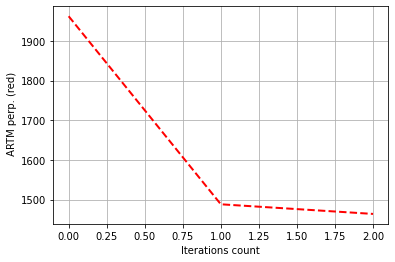

In [23]:
model_1 = train_1(model_1, 2, 3)

In [24]:
model_1 = train_2(model_1, 200, -0.15, 1)

Sparsity Phi: 0.719 ARTM)
Sparsity Theta: 0.817 (ARTM)
Kernel contrast: 0.486 (ARTM)
Kernel purity: 0.585 (ARTM)
Perplexity: 391.935 (ARTM)


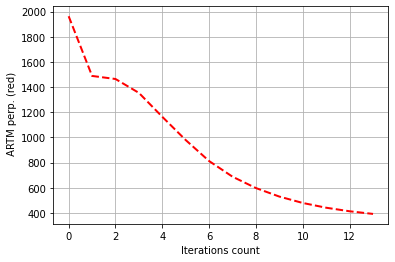

In [25]:
# посмотрим на качество
print_measures(model_1)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.014 (ARTM)
Kernel purity: 0.004 (ARTM)
Perplexity: 1458.852 (ARTM)


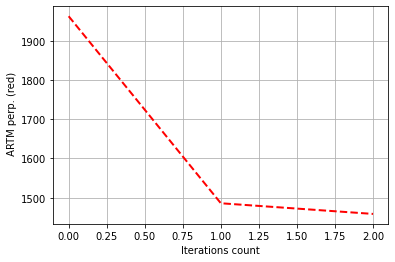

Sparsity Phi: 0.609 ARTM)
Sparsity Theta: 0.730 (ARTM)
Kernel contrast: 0.415 (ARTM)
Kernel purity: 0.559 (ARTM)
Perplexity: 463.251 (ARTM)


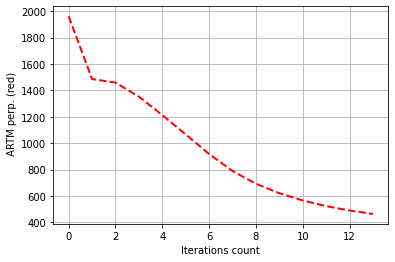

In [26]:
model_2 = create_model(150, 0.3, 0.1)
model_2 = train_1(model_2, 2, 3)
model_2 = train_2(model_2, 150, -0.1, 1)
print_measures(model_2)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.005 (ARTM)
Kernel purity: 0.002 (ARTM)
Perplexity: 1462.284 (ARTM)


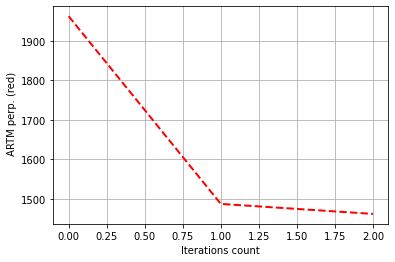

Sparsity Phi: 0.713 ARTM)
Sparsity Theta: 0.816 (ARTM)
Kernel contrast: 0.502 (ARTM)
Kernel purity: 0.592 (ARTM)
Perplexity: 363.592 (ARTM)


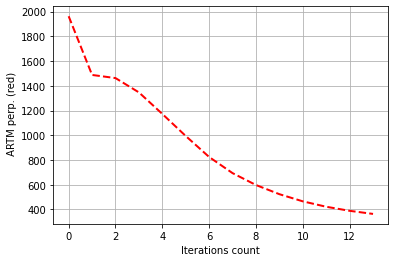

In [27]:
model_3 = create_model(250, 0.3, 0.1)
model_3 = train_1(model_3, 2, 3)
model_3 = train_2(model_3, 250, -0.1, 1)
print_measures(model_3)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.000 (ARTM)
Kernel purity: 0.000 (ARTM)
Perplexity: 1947.632 (ARTM)


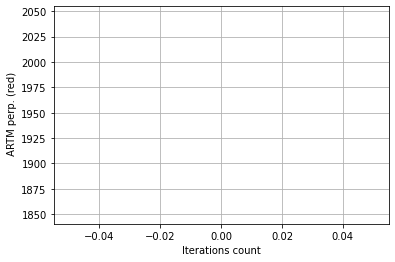

Sparsity Phi: 0.753 ARTM)
Sparsity Theta: 0.861 (ARTM)
Kernel contrast: 0.540 (ARTM)
Kernel purity: 0.632 (ARTM)
Perplexity: 337.153 (ARTM)


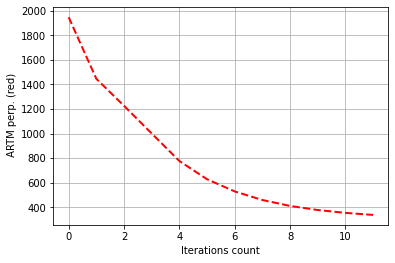

In [28]:
model_4 = create_model(250, 0.3, 0.1)
model_4 = train_1(model_4, 3, 1)
model_4 = train_2(model_4, 250, -0.1, 1)
print_measures(model_4)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.029 (ARTM)
Kernel purity: 0.023 (ARTM)
Perplexity: 1260.690 (ARTM)


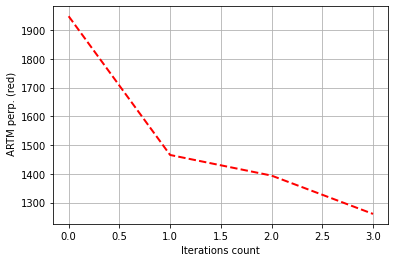

Sparsity Phi: 0.796 ARTM)
Sparsity Theta: 0.866 (ARTM)
Kernel contrast: 0.590 (ARTM)
Kernel purity: 0.690 (ARTM)
Perplexity: 317.260 (ARTM)


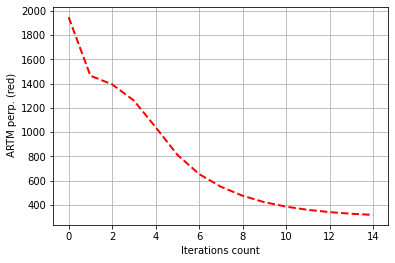

In [29]:
model_6 = create_model(250, 0.3, 0.1)
model_6 = train_1(model_6, 3, 4)
model_6 = train_2(model_6, 250, -0.1, 1)
print_measures(model_6)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.029 (ARTM)
Kernel purity: 0.023 (ARTM)
Perplexity: 1260.690 (ARTM)


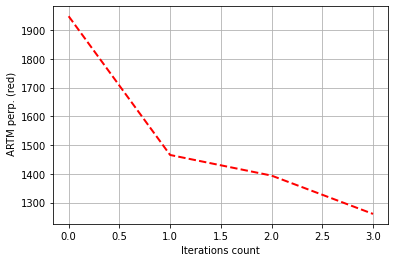

Sparsity Phi: 0.959 ARTM)
Sparsity Theta: 0.865 (ARTM)
Kernel contrast: 0.761 (ARTM)
Kernel purity: 0.885 (ARTM)
Perplexity: 281.906 (ARTM)


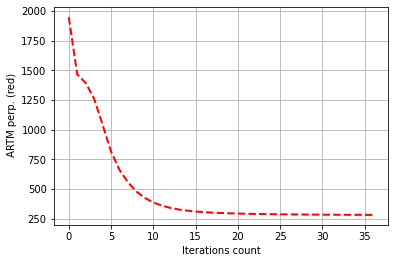

In [30]:
model_8 = create_model(250, 0.3, 0.1)
model_8 = train_1(model_8, 3, 4)
model_8 = train_2(model_8, 250, -0.1, 3)
print_measures(model_8)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.034 (ARTM)
Kernel purity: 0.028 (ARTM)
Perplexity: 1259.412 (ARTM)


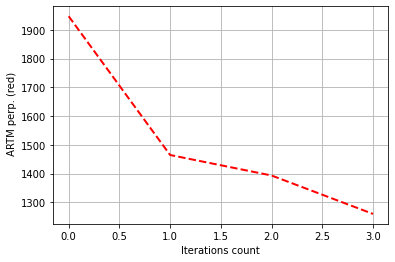

Sparsity Phi: 0.944 ARTM)
Sparsity Theta: 0.847 (ARTM)
Kernel contrast: 0.687 (ARTM)
Kernel purity: 0.872 (ARTM)
Perplexity: 315.787 (ARTM)


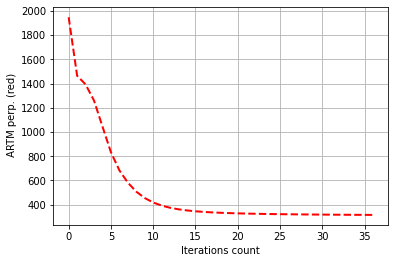

In [31]:
model_9 = create_model(200, 0.3, 0.1)
model_9 = train_1(model_9, 3, 4)
model_9 = train_2(model_9, 200, -0.1, 3)
print_measures(model_9)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.023 (ARTM)
Kernel purity: 0.020 (ARTM)
Perplexity: 1293.063 (ARTM)


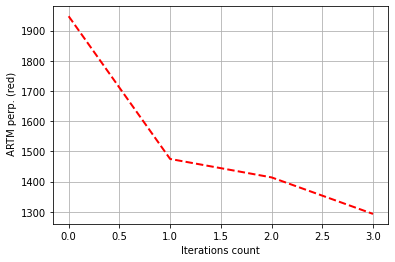

Sparsity Phi: 0.937 ARTM)
Sparsity Theta: 0.892 (ARTM)
Kernel contrast: 0.613 (ARTM)
Kernel purity: 0.729 (ARTM)
Perplexity: 296.953 (ARTM)


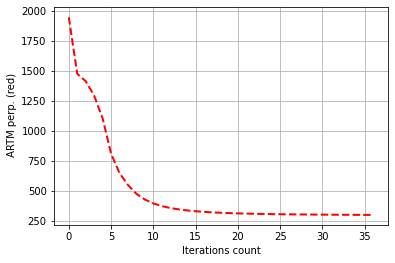

In [32]:
model_10 = create_model(250, 0.4, 0.3)
model_10 = train_1(model_10, 3, 4)
model_10 = train_2(model_10, 250, -0.3, 3)
print_measures(model_10)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.029 (ARTM)
Kernel purity: 0.023 (ARTM)
Perplexity: 1260.691 (ARTM)


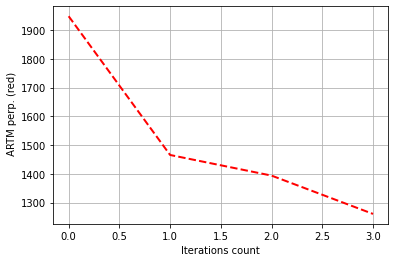

Sparsity Phi: 0.959 ARTM)
Sparsity Theta: 0.865 (ARTM)
Kernel contrast: 0.761 (ARTM)
Kernel purity: 0.885 (ARTM)
Perplexity: 281.907 (ARTM)


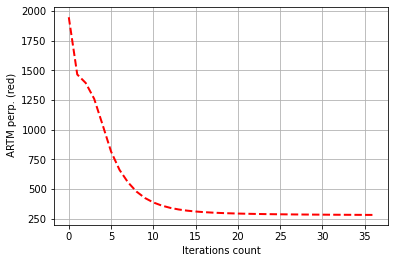

In [33]:
model_11 = create_model(250, 0.2, 0.1)
model_11 = train_1(model_11, 3, 4)
model_11 = train_2(model_11, 250, -0.1, 3)
print_measures(model_11)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.027 (ARTM)
Kernel purity: 0.022 (ARTM)
Perplexity: 1269.384 (ARTM)


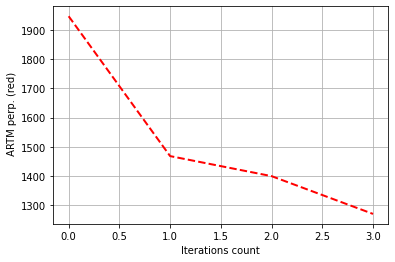

Sparsity Phi: 0.953 ARTM)
Sparsity Theta: 0.872 (ARTM)
Kernel contrast: 0.712 (ARTM)
Kernel purity: 0.844 (ARTM)
Perplexity: 285.024 (ARTM)


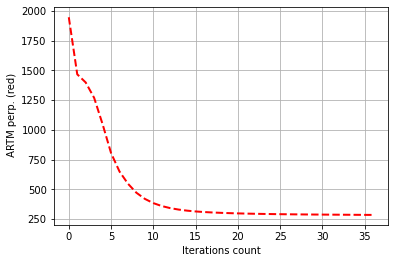

In [36]:
model_12 = create_model(250, 0.2, 0.15)
model_12 = train_1(model_12, 3, 4)
model_12 = train_2(model_12, 250, -0.15, 3)
print_measures(model_12)

Сначала я изменяла значения doc_pass и coll_pass в train_1 и coll_pass в train_2: начиная со всех единиц и постепенно увеличивая значения на один. Model_4 демонстрирует промежуточные результаты при (3,1,1). После я увеличивала coll_pass в train_1 - model_6 демонстрирует результаты при (3,4,1). Далее был постепенно увеличен coll_pass в train_2 до 3: model_8 демонстрирует результаты при (3,4,3). Результаты метрик получились довольно хорошими и я перешла к тестированию других параметров.

Уменьшение словаря до 200 не улучшило перформанс модели после регуляризации (model_9). Увеличение первого tau в train_1 также ухудшило результаты (model_10). Понижение первого tau в train_1 с 0.3 на 0.2 немного улучшило перворманс (на несколько тысячных после запятой) (model_11). Изменение второго tau в train_1 и train_2 тоже ухудшило результаты (model_12).

Таким образом у итоговой модели следующие характеристики: словарь - 250,  doc_pass - 3 и coll_pass - 4 (train_1) и coll_pass - 3 в train_2. Tau для регулязаторов в train_1 - 0.2, 0.1, tau для регулязаторов в train_2 - -0.1.

Перплексия хорошей модели около 200-1000. В принципе у всех моделей после регуляризации значения перплексити входят в этот промежуток. Попробуем сравнить получившиеся темы у нескольких моделей:


In [35]:
for i in range(20):
  topic1 = model_1.topic_names[i]
  topic2 = model_11.topic_names[i]

  try:
    words_1 = [x for x in model_1.score_tracker['TopTokensScore_1'].last_tokens[topic1]]
    words_2 = [x for x in model_11.score_tracker['TopTokensScore_1'].last_tokens[topic2]]
    print("%-5s%-65s" % (str(i), " - ".join(words_1)))
    print("%-5s%-65s\n" % (str(i), " - ".join(words_2)))
  except KeyError:
    continue

0    список - значение - входить - пункт - включать - фамилия - европа - относиться - следующий - страна
0    следующий - различный - входить - относиться - начинать - состоять - связать - настоящий_время - наиболее - кроме

1    декабрь - покинуть - успех - остаться - уход - объявить - провести - несмотря - выступить - отказаться
1    остаться - декабрь - английский - покинуть - уход - вернуться - несмотря - ещё - состояться - принести

2    император - царь - греческий - сообщать - бежать - лев - константин - согласно - источник - вероятно
2    император - царь - известно - греческий - лев - возможно - сообщать - согласно - называть - вероятно

3    деятельность - организация - кафедра - подготовка - база - организовать - учебный - формирование - обеспечение - подразделение
3    деятельность - подготовка - формирование - подразделение - конференция - работник - осуществлять - вести - качество - технический

4    немецкий - операция - соединение - германский - фон - берлин - германия 

Я выбрала следующие три темы для лучшей модели model_11:

1) норвежская экспедиция:

15   экспедиция - норвегия - достигнуть - норвежский - судно - путешествие - поход - пройти - капитан - возвращение

2) должности

7    должность - комитет - народный - руководить - вступить - секретарь - советник - помощник - деятель - занимать

3) коммуна

10   км² - административный_центр - коммуна - население_коммуна - 60 - коммуна_— - коммуна_губерния - город_официальный - язык_коммуна - 2007_год

# Домашнее задание


Основаная задача - **построить хорошую тематическую модель с интерпретируемыми топиками с помощью BigARTM**.

1) сделайте нормализацию (если pymorphy2 работает долго используйте mystem или попробуйте установить быструю версию - `pip install pymorphy2[fast]`, можно использовать какой-то другой токенизатор) 

2) добавьте нграммы (в тетрадке есть закомменченая ячейка с Phrases, можно также попробовать другие способы построить нграммы); 

3) сохраните тексты .vw формате;

4) сделайте хороший словарь (отфильтруйте слишком частотные и редкие слова, попробуйте удалить стоп-слова, сохраните словарь и посмотрите на него, вдруг что-то плохое сразу будет заметно - из словаря можно просто вручную или правилом удалять строки, при загрузке ничего не сломается); 

5) постройте несколько ARTM моделей (переберите количество тем, поменяйте значения tau у регуляризаторов), если получаются плохие темы, поработайте дополнительно над предобработкой и словарем; 

6) для самой хорошей модели в отдельной ячейке напечатайте 3 хороших (на ваш вкус) темы

7) в другой ячейке нарисуйте график обучения этой модели 

8) в третьей ячейки опишите какие параметры (количество тем, регуляризаторы, их tau) вы использовали и как обучали (например, после скольки проходов добавили регуляризатор разрежнивания тем (Phi), добавляли ли разреженность документам (Theta) и когда, как повышали значения, сколько итерации модель продожала улучшаться (снижалась перплексия, росли другие метрики);

Сохраните тетрадку с экспериментами и положите её на гитхаб, ссылку на неё укажите в форме.

**Оцениваться будут главным образом пункты 6, 7 и 8. (3, 1, 4 баллов соответственно). Чтобы заработать остальные 2 балла, нужно хотя бы немного изменить мой код на промежуточных этапах (добавить что-то, указать другие параметры и т.д). **